In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


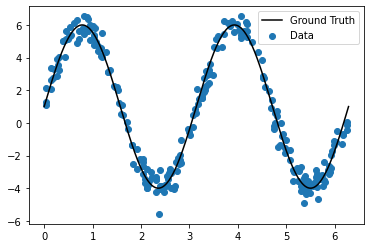

In [2]:
A_gt = 5
OMEGA_gt = 2
D_gt = 1

def f(x, A, OMEGA, D, phi):
    return A * torch.sin(OMEGA * x + phi) + D

x_gt = torch.linspace(0, 2 * np.pi, 1000)
y_gt = f(x_gt, A_gt, OMEGA_gt, D_gt, 0)

def generate_data(A, OMEGA, D, phi, n=1000, noise_amp=0.1):
    x = torch.rand(n) * 2 * np.pi
    y = f(x, A, OMEGA, D, phi) + noise_amp * torch.randn(n) * A

    # sort x and y
    x, indices = torch.sort(x)
    y = y[indices]

    return x, y

x_final, y_final = generate_data(n = 250, noise_amp=0.1, A=A_gt, OMEGA=OMEGA_gt, D=D_gt, phi=0)

plt.scatter(x_final, y_final, label='Data')
plt.plot(x_gt, y_gt, label='Ground Truth', color='k')
plt.legend()
plt.show()

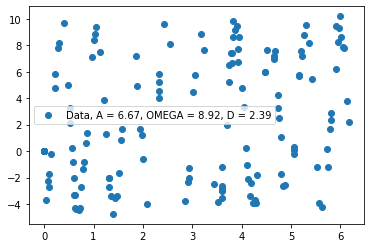

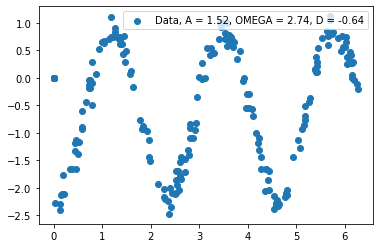

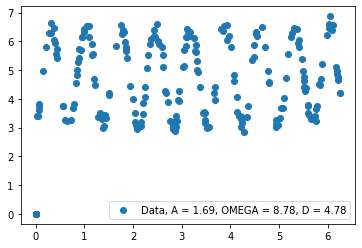

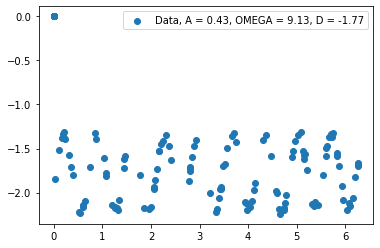

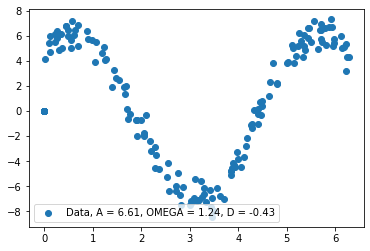

In [3]:
# I will generate N = 1000 different datasets with different A, OMEGA and D values

N = 10000
A_range = [0.1, 10]
OMEGA_range = [1, 10]
D_range = [-5, 5]
n_range = [100, 250]
phi_range = [0, 2*3.14]

def generate_dataset(noise_amp=0.1):
    A = (A_range[1] - A_range[0]) * torch.rand(1) + A_range[0]
    OMEGA = (OMEGA_range[1] - OMEGA_range[0]) * torch.rand(1) + OMEGA_range[0]
    D = (D_range[1] - D_range[0]) * torch.rand(1) + D_range[0] 
    n = int((n_range[1] - n_range[0]) * torch.rand(1) + n_range[0])
    phi = (phi_range[1] - phi_range[0]) * torch.rand(1) + D_range[0] 
    x, y = generate_data(A, OMEGA, D, phi, n, noise_amp)

    x = torch.cat([torch.zeros(n_range[-1] - n), x])
    y = torch.cat([torch.zeros(n_range[-1] - n), y])
    return x, y, A, OMEGA, D

datasets = [generate_dataset(noise_amp=0.1) for _ in range(N)]

for i in range(5):
    x, y, A, OMEGA, D = datasets[i]
    plt.scatter(x, y, label='Data, A = {:.2f}, OMEGA = {:.2f}, D = {:.2f}'.format(A.item(), OMEGA.item(), D.item()))
    plt.legend()
    plt.show()


torch.Size([1, 250, 1])
torch.Size([1, 250, 3])


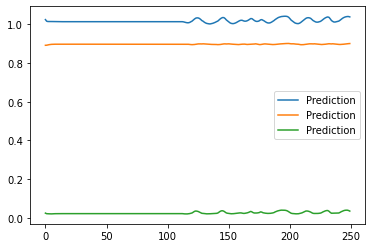

In [4]:
class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_units, output_size):
        super(CustomRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_units = num_units
        self.output_size = output_size
        
        self.rnns = [nn.GRU(input_size, hidden_size, batch_first=True)]
        for _ in range(num_units - 1):
            self.rnns.append(nn.GRU(hidden_size, hidden_size, batch_first=True))
                
        self.rnns = nn.ModuleList(self.rnns)
        self.fc = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.init_h0 = nn.Parameter(torch.zeros(1, 1, hidden_size))  # Shape: (num_layers, batch_size, hidden_size)
        
    def forward(self, x):
        x = x.to(device)
        h0 = self.init_h0.expand(-1, x.size(0), -1).to(device).contiguous()  # Shape: (num_layers, batch_size, hidden_size)
        
        for rnn in self.rnns:
            x, h0 = rnn(x, h0)
            
        out = x
        out = self.fc(out)
        out = self.leaky_relu(out)
        out = self.fc2(out)
        out = self.leaky_relu(out)
        out = self.fc3(out)

        out_A = out[:, :, 0]
        out_A = torch.exp(out_A)
        out_OMEGA = out[:, :, 1]
        out_OMEGA = torch.exp(out_OMEGA)
        out_D = out[:, :, 2]
        out[:, :, 0] = out_A
        out[:, :, 1] = out_OMEGA
        out[:, :, 2] = out_D
        return out
    
model = CustomRNN(1, 32, 3, 3)
model.to(device)

x_0, y_0, A_0, OMEGA_0, D_0 = datasets[0]
y_0 = y_0.cpu().unsqueeze(-1).unsqueeze(0)
print(y_0.shape)
y_pred = model(y_0)
print(y_pred.shape)

# plot the evolution of the prediction
y_pred = y_pred.cpu().squeeze().detach().numpy()
plt.plot(y_pred, label='Prediction')
plt.legend()
plt.show()

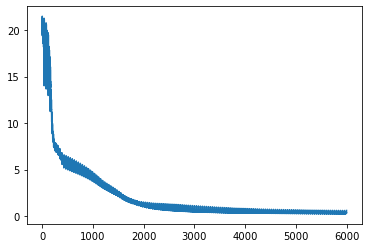

In [5]:
batch_size = 256
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

losses = []
for e in range(150):
    for i in range(0, len(datasets), batch_size):
        model.train()
        model.zero_grad()
        batch = datasets[i:i+batch_size]
        x_batch = torch.stack([x for x, _, _, _, _ in batch])
        y_batch = torch.stack([y for _, y, _, _, _ in batch]).unsqueeze(-1)
        A_batch = torch.stack([A for _, _, A, _, _ in batch]).repeat(1, y_batch.shape[1]).unsqueeze(-1)
        OMEGA_batch = torch.stack([OMEGA for _, _, _, OMEGA, _ in batch]).repeat(1, y_batch.shape[1]).unsqueeze(-1)
        D_batch = torch.stack([D for _, _, _, _, D in batch]).repeat(1, y_batch.shape[1]).unsqueeze(-1)


        target = torch.cat([A_batch, OMEGA_batch, D_batch], dim=-1).to(device)
        y_pred = model(y_batch)

        y_pred = y_pred[:, -1, :]
        target = target[:, -1, :]

        loss = nn.MSELoss()(y_pred, target)
        loss.backward()    
        
        losses.append(loss.item())

        print('Epoch', e, 'Batch:', i, 'Loss:', loss.item(), end='\r')
        optimizer.step()

plt.plot(losses)

torch.Size([1, 250, 1])
torch.Size([1, 250, 3])


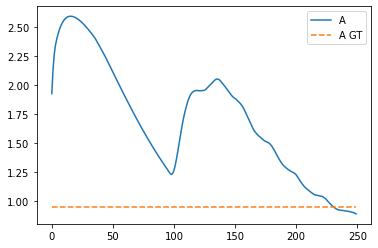

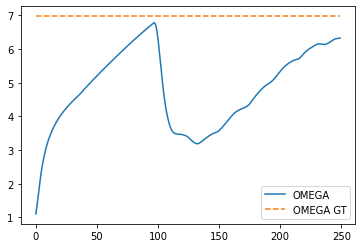

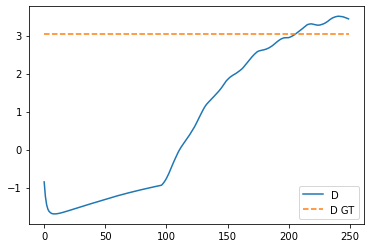

In [6]:
random_index = np.random.randint(0, len(datasets))
x_0, y_0, A_0, OMEGA_0, D_0 = datasets[random_index]
y_0 = y_0.unsqueeze(-1).unsqueeze(0)
print(y_0.shape)
y_pred = model(y_0)
print(y_pred.shape)

A_pred = y_pred[0, :, 0].cpu().detach().numpy()
OMEGA_pred = y_pred[0, :, 1].cpu().detach().numpy()
D_pred = y_pred[0, :, 2].cpu().detach().numpy()

plt.plot(A_pred, label='A')
plt.plot([A_0.item()] * len(A_pred), label='A GT', linestyle='--')
plt.legend()
plt.show()
plt.plot(OMEGA_pred, label='OMEGA')
plt.plot([OMEGA_0.item()] * len(OMEGA_pred), label='OMEGA GT', linestyle='--')
plt.legend()
plt.show()
plt.plot(D_pred, label='D')
plt.plot([D_0.item()] * len(D_pred), label='D GT', linestyle='--')
plt.legend()
plt.show()